In [ ]:
!pip install tensorflow-datasets


In [ ]:
import tarfile
import os

dataset_tar = r"C:\Users\Admin\Downloads\speech_commands_v0.02.tar.gz"
extract_path = r"C:\datasets\speech_commands_v0.02"

if not os.path.exists(extract_path):
    os.makedirs(extract_path)

with tarfile.open(dataset_tar, "r:gz") as tar:
    tar.extractall(path=extract_path)

print("Dataset extracted to:", extract_path)


Dataset extracted to: C:\datasets\speech_commands_v0.02


In [ ]:
#Imports and Setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
import umap
from tensorflow.keras import layers, models, optimizers

sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (7,6)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)


In [ ]:
#Dataset Path and Classes

# Update this to where you extracted your tar.gz
DATASET_PATH = r"C:\Users\Admin\Downloads\speech_commands_v0.02"

# Classes to use (10 commands for simplicity)
CLASSES = ["yes","no","up","down","left","right","on","off","stop","go"]
MAX_FILES_PER_CLASS = 200  # limit files per class for faster processing


In [12]:
#Load Audio and Extract MFCC Features
def load_speech_commands(path, classes=CLASSES, max_files_per_class=MAX_FILES_PER_CLASS):
    X, y = [], []
    for idx, label in enumerate(classes):
        class_folder = os.path.join(path, label)
        if not os.path.exists(class_folder):
            print(f"Warning: Folder {class_folder} not found, skipping class {label}")
            continue
        files = os.listdir(class_folder)[:max_files_per_class]
        for f in files:
            file_path = os.path.join(class_folder, f)
            try:
                audio, sr = librosa.load(file_path, sr=16000)
                # Correct MFCC call
                mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
                mfcc_mean = np.mean(mfcc.T, axis=0)
                X.append(mfcc_mean)
                y.append(idx)
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
    return np.array(X), np.array(y)

print("Loading dataset and extracting MFCC features...")
X, y = load_speech_commands(DATASET_PATH)
print("Dataset shape:", X.shape, "Labels shape:", y.shape)


Loading dataset and extracting MFCC features...
Dataset shape: (2000, 20) Labels shape: (2000,)


In [13]:
# ------------------------- 4) Train/Test Split & Scaling -------------------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

TEST_SIZE = 0.3
RANDOM_STATE = 42

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

# Standardize features (zero mean, unit variance)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (1400, 20) Test shape: (600, 20)


In [14]:
# ------------------------- 5) Baseline Classification (No DR) -------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
import time

# Define classifiers
CLASSIFIERS = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    "Linear SVM": SVC(kernel="linear", random_state=RANDOM_STATE),
    "kNN": KNeighborsClassifier(n_neighbors=5)
}

# Helper function to evaluate classifiers
def eval_and_time(clf, Xtr, Xte, ytr, yte):
    t0 = time.time()
    clf.fit(Xtr, ytr)
    preds = clf.predict(Xte)
    dt = time.time() - t0
    return accuracy_score(yte, preds), f1_score(yte, preds, average='macro'), dt

# Container to store results
records = []

print("=== Baseline Classification (No DR) ===")
for name, clf in CLASSIFIERS.items():
    acc, f1, t_elapsed = eval_and_time(clf, X_train, X_test, y_train, y_test)
    records.append(("Baseline", "-", name, acc, f1, t_elapsed))
    print(f"{name:20s} | Accuracy={acc:.4f} | F1={f1:.4f} | Time={t_elapsed:.3f}s")


=== Baseline Classification (No DR) ===
Logistic Regression  | Accuracy=0.4350 | F1=0.4334 | Time=0.104s
Linear SVM           | Accuracy=0.4267 | F1=0.4248 | Time=0.481s
kNN                  | Accuracy=0.4133 | F1=0.4103 | Time=5.241s


In [16]:
# ------------------------- 6) Linear DR: PCA -------------------------
print("\n=== Linear DR: PCA ===")

PCA_DIMS = [10, 20]   # FIXED

for n in PCA_DIMS:
    pca = PCA(n_components=n, random_state=RANDOM_STATE)
    Xtr_pca = pca.fit_transform(X_train)
    Xte_pca = pca.transform(X_test)
    
    for name, clf in CLASSIFIERS.items():
        acc, f1, t = eval_and_time(clf, Xtr_pca, Xte_pca, y_train, y_test)
        records.append(("PCA", n, name, acc, f1, t))
        print(f"PCA n={n}, {name:20s} | Accuracy={acc:.4f} | F1={f1:.4f} | Time={t:.3f}s")



=== Linear DR: PCA ===
PCA n=10, Logistic Regression  | Accuracy=0.3467 | F1=0.3444 | Time=0.047s
PCA n=10, Linear SVM           | Accuracy=0.3617 | F1=0.3607 | Time=0.359s
PCA n=10, kNN                  | Accuracy=0.3733 | F1=0.3674 | Time=0.025s
PCA n=20, Logistic Regression  | Accuracy=0.4350 | F1=0.4334 | Time=0.045s
PCA n=20, Linear SVM           | Accuracy=0.4267 | F1=0.4248 | Time=0.464s
PCA n=20, kNN                  | Accuracy=0.4133 | F1=0.4103 | Time=0.018s


In [17]:
# ------------------------- 7) Linear DR: ICA -------------------------
print("\n=== Linear DR: ICA ===")

ICA_DIMS = [10, 20]   # fixed maximum as MFCC=20 dims

for n in ICA_DIMS:
    ica = FastICA(n_components=n, max_iter=1000, random_state=RANDOM_STATE)
    
    try:
        Xtr_ica = ica.fit_transform(X_train)
        Xte_ica = ica.transform(X_test)
    except Exception as e:
        print(f"ICA failed for n={n}: {e}")
        continue

    for name, clf in CLASSIFIERS.items():
        acc, f1, t = eval_and_time(clf, Xtr_ica, Xte_ica, y_train, y_test)
        records.append(("ICA", n, name, acc, f1, t))
        print(f"ICA n={n}, {name:20s} | Accuracy={acc:.4f} | F1={f1:.4f} | Time={t:.3f}s")



=== Linear DR: ICA ===
ICA n=10, Logistic Regression  | Accuracy=0.3467 | F1=0.3445 | Time=0.026s
ICA n=10, Linear SVM           | Accuracy=0.3617 | F1=0.3609 | Time=0.293s
ICA n=10, kNN                  | Accuracy=0.3750 | F1=0.3697 | Time=0.036s
ICA n=20, Logistic Regression  | Accuracy=0.4317 | F1=0.4302 | Time=0.027s
ICA n=20, Linear SVM           | Accuracy=0.4250 | F1=0.4232 | Time=0.456s
ICA n=20, kNN                  | Accuracy=0.4233 | F1=0.4171 | Time=0.015s


In [18]:
# ------------------------- 8) Nonlinear DR: UMAP -------------------------
print("\n=== Nonlinear DR: UMAP ===")

UMAP_DIMS = [10, 20]   # only these 2 are meaningful for MFCC 20 dims

for n in UMAP_DIMS:
    reducer = umap.UMAP(n_components=n, random_state=RANDOM_STATE)

    try:
        Xtr_umap = reducer.fit_transform(X_train)
        Xte_umap = reducer.transform(X_test)
    except Exception as e:
        print(f"UMAP failed for n={n}: {e}")
        continue

    for name, clf in CLASSIFIERS.items():
        acc, f1, t = eval_and_time(clf, Xtr_umap, Xte_umap, y_train, y_test)
        records.append(("UMAP", n, name, acc, f1, t))
        print(f"UMAP n={n}, {name:20s} | Accuracy={acc:.4f} | F1={f1:.4f} | Time={t:.3f}s")



=== Nonlinear DR: UMAP ===


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP n=10, Logistic Regression  | Accuracy=0.1467 | F1=0.1327 | Time=1.481s
UMAP n=10, Linear SVM           | Accuracy=0.1383 | F1=0.1265 | Time=0.281s
UMAP n=10, kNN                  | Accuracy=0.2550 | F1=0.2539 | Time=0.012s


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP n=20, Logistic Regression  | Accuracy=0.1400 | F1=0.1308 | Time=1.070s
UMAP n=20, Linear SVM           | Accuracy=0.1417 | F1=0.1232 | Time=0.308s
UMAP n=20, kNN                  | Accuracy=0.2317 | F1=0.2283 | Time=0.015s


In [19]:
# ------------------------- 9) Nonlinear DR: Autoencoder -------------------------
print("\n=== Nonlinear DR: Autoencoder ===")

input_dim = X_train.shape[1]   # = 20

AE_DIMS = [10, 15, 20]   # These bottleneck sizes make sense for MFCC

for bottleneck in AE_DIMS:
    tf.keras.backend.clear_session()

    # Encoder
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(128, activation='relu')(inp)
    bott = layers.Dense(bottleneck, activation='linear', name='bottleneck')(x)

    # Decoder
    x = layers.Dense(128, activation='relu')(bott)
    out = layers.Dense(input_dim, activation='linear')(x)

    # Autoencoder model
    ae = models.Model(inp, out)
    encoder = models.Model(inp, bott)
    ae.compile(optimizer=optimizers.Adam(1e-3), loss='mse')

    # Train AE
    ae.fit(X_train, X_train, epochs=40, batch_size=64,
           validation_split=0.1, verbose=0)

    # Transform data
    Xtr_ae = encoder.predict(X_train)
    Xte_ae = encoder.predict(X_test)

    # Evaluate classifiers
    for name, clf in CLASSIFIERS.items():
        acc, f1, t = eval_and_time(clf, Xtr_ae, Xte_ae, y_train, y_test)
        records.append(("Autoencoder", bottleneck, name, acc, f1, t))
        print(f"AE bottleneck={bottleneck}, {name:20s} | "
              f"Accuracy={acc:.4f} | F1={f1:.4f} | Time={t:.3f}s")



=== Nonlinear DR: Autoencoder ===



44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
AE bottleneck=10, Logistic Regression  | Accuracy=0.3183 | F1=0.3138 | Time=0.058s
AE bottleneck=10, Linear SVM           | Accuracy=0.3083 | F1=0.3014 | Time=0.467s
AE bottleneck=10, kNN                  | Accuracy=0.3533 | F1=0.3529 | Time=0.024s
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
AE bottleneck=15, Logistic Regression  | Accuracy=0.3867 | F1=0.3853 | Time=0.100s
AE bottleneck=15, Linear SVM           | Accuracy=0.3767 | F1=0.3769 | Time=0.478s
AE bottleneck=15, kNN                  | Accuracy=0.3750 | F1=0.3720 | Time=0.042s
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
AE bottleneck=20, Logistic Regression  | Accuracy=0.4383 | F1=0.4358 | Time=0.142s
AE bottleneck=20, Linear SVM           | Accuracy=0.4350 | F1=0.4333 | Time=0.430s
AE bottleneck=20, kNN                  | Accuracy=0.4250 | F1=0.4210 | Time=0.019s



Saving final results & generating visualizations...
Saved: audio_results.csv


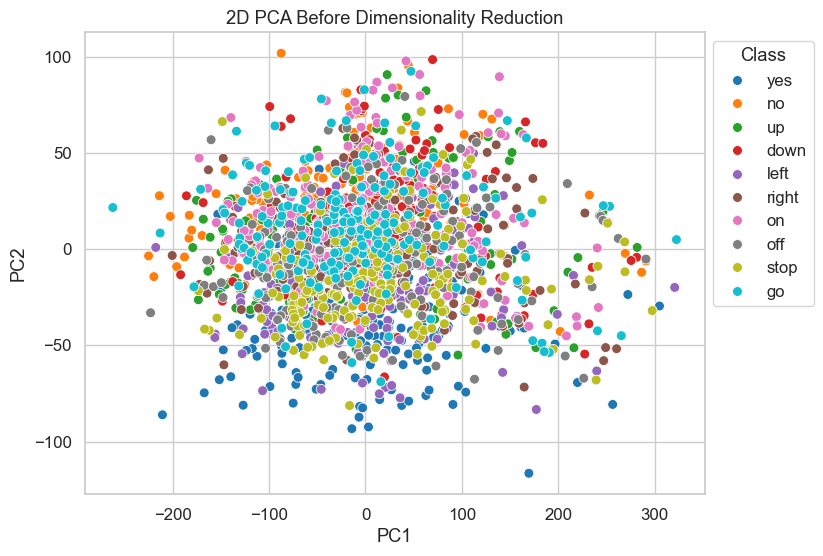

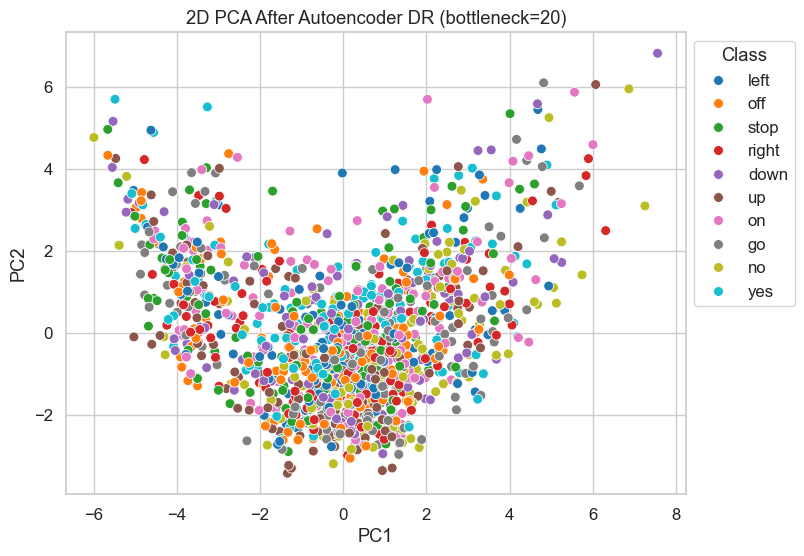

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


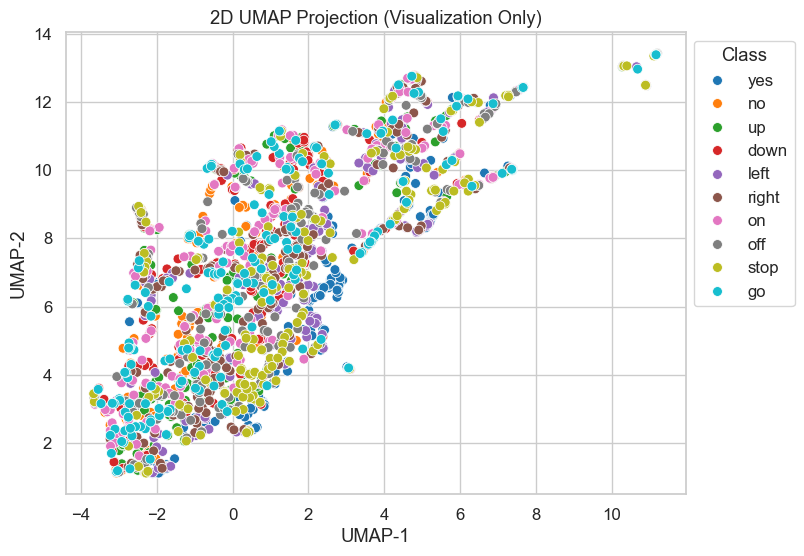


================ FINAL SUMMARY ================

         Method n_components           Classifier  Accuracy        F1  \
33  Autoencoder           20  Logistic Regression  0.438333  0.435759   
0      Baseline            -  Logistic Regression  0.435000  0.433368   
6           PCA           20  Logistic Regression  0.435000  0.433368   
34  Autoencoder           20           Linear SVM  0.435000  0.433329   
12          PCA           20  Logistic Regression  0.435000  0.433368   

        Time  
33  0.142488  
0   0.103746  
6   0.051324  
34  0.430256  
12  0.045327  

Best method overall = Autoencoder | components = 20 | classifier = Logistic Regression


In [21]:
# ========================= 10) FINAL VISUALIZATION + REPORT =========================

print("\nSaving final results & generating visualizations...")

# Save CSV
df_results = pd.DataFrame(records, columns=["Method","n_components","Classifier","Accuracy","F1","Time"])
df_results.to_csv("audio_results.csv", index=False)
print("Saved: audio_results.csv")


# --------------------- Visualization 1: PCA BEFORE DR ---------------------
pca_vis_before = PCA(n_components=2)
X_vis_before = pca_vis_before.fit_transform(X)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_vis_before[:,0], y=X_vis_before[:,1],
    hue=[CLASSES[i] for i in y], palette='tab10', s=50
)
plt.title("2D PCA Before Dimensionality Reduction")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Class", bbox_to_anchor=(1,1))
plt.show()


# --------------------- Visualization 2: PCA AFTER DR (AE bottleneck=15) ---------------------
# Using the middle bottleneck size
pca_vis_after = PCA(n_components=2)
X_vis_after = pca_vis_after.fit_transform(Xtr_ae[:,:])  # Xtr_ae already computed for last AE

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_vis_after[:,0], y=X_vis_after[:,1],
    hue=[CLASSES[i] for i in y_train], palette='tab10', s=50
)
plt.title("2D PCA After Autoencoder DR (bottleneck=20)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Class", bbox_to_anchor=(1,1))
plt.show()


# --------------------- Visualization 3: UMAP 2D (Optional) ---------------------
try:
    umap_2d = umap.UMAP(n_components=2, random_state=42)
    X_umap = umap_2d.fit_transform(X)

    plt.figure(figsize=(8,6))
    sns.scatterplot(
        x=X_umap[:,0], y=X_umap[:,1],
        hue=[CLASSES[i] for i in y], palette='tab10', s=50
    )
    plt.title("2D UMAP Projection (Visualization Only)")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.legend(title="Class", bbox_to_anchor=(1,1))
    plt.show()
except:
    print("UMAP visualization skipped due to computational limitations.")




# --------------------- Final Summary ---------------------
print("\n================ FINAL SUMMARY ================\n")
best = df_results.sort_values("Accuracy", ascending=False).head(5)
print(best)

print("\nBest method overall =", best.iloc[0]["Method"],
      "| components =", best.iloc[0]["n_components"],
      "| classifier =", best.iloc[0]["Classifier"])


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


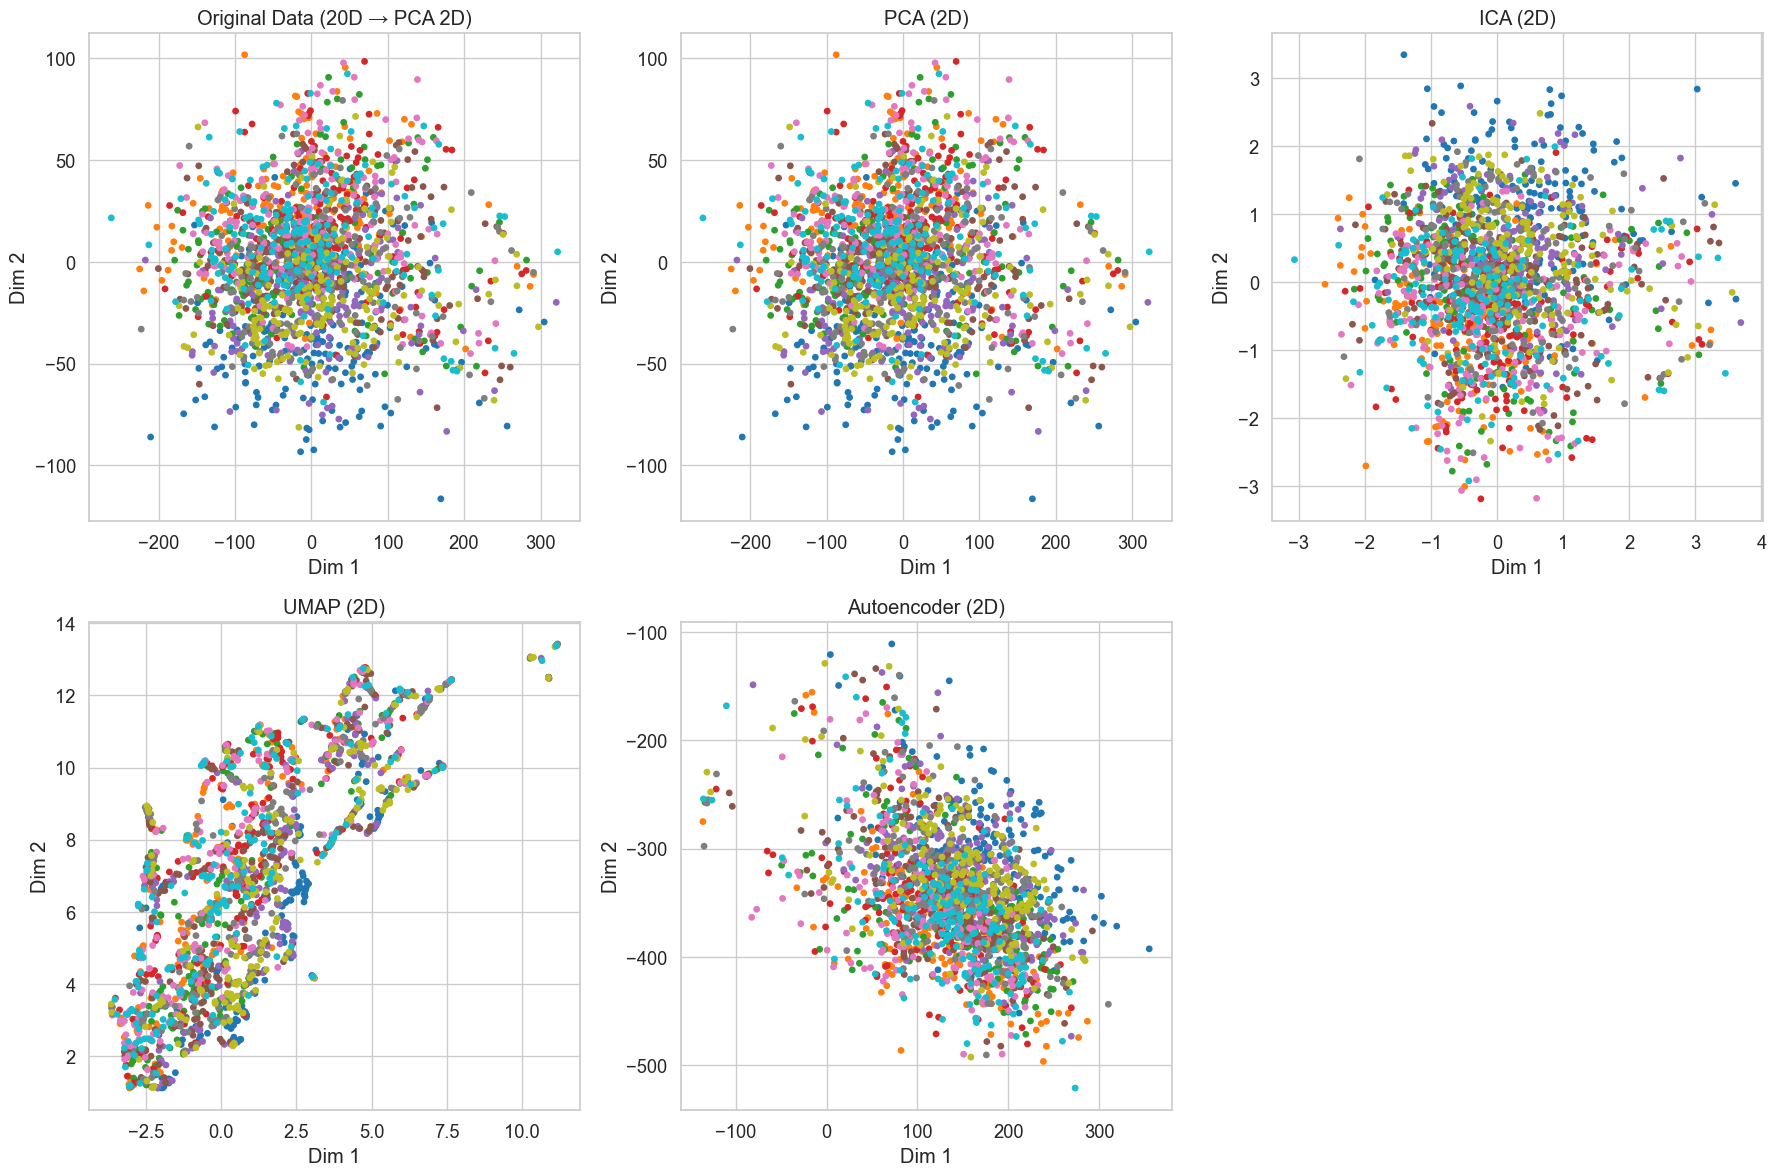

In [24]:
# ============================================
#  AUDIO DATA – DIMENSIONALITY REDUCTION VISUALIZATION
# ============================================
from sklearn.decomposition import PCA, FastICA
import umap
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2)

# -------------- 1) PCA (Baseline Projection for Original Data) --------------
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X)

# -------------- 2) PCA 2D --------------
pca_dr = PCA(n_components=2)
X_pca_dr = pca_dr.fit_transform(X)

# -------------- 3) ICA 2D --------------
ica_dr = FastICA(n_components=2, random_state=42, max_iter=1000)
X_ica_dr = ica_dr.fit_transform(X)

# -------------- 4) UMAP 2D --------------
umap_dr = umap.UMAP(n_components=2, random_state=42)
X_umap_dr = umap_dr.fit_transform(X)

# -------------- 5) Autoencoder (2D bottleneck) --------------
input_dim = X.shape[1]

tf.keras.backend.clear_session()
inp = layers.Input(shape=(input_dim,))
e = layers.Dense(64, activation='relu')(inp)
z = layers.Dense(2, activation='linear', name='code')(e)
d = layers.Dense(64, activation='relu')(z)
out = layers.Dense(input_dim, activation='linear')(d)

ae = models.Model(inp, out)
encoder = models.Model(inp, z)

ae.compile(optimizer='adam', loss='mse')
ae.fit(X, X, epochs=50, batch_size=64, verbose=0)

X_ae2 = encoder.predict(X)

# ------------------------------------------------------------
#   PLOT: ORIGINAL (PCA Projection) + PCA + ICA + UMAP + AE
# ------------------------------------------------------------
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs = axs.flatten()

titles = [
    "Original Data (20D → PCA 2D)",
    "PCA (2D)",
    "ICA (2D)",
    "UMAP (2D)",
    "Autoencoder (2D)"
]

datasets = [X_pca2, X_pca_dr, X_ica_dr, X_umap_dr, X_ae2]

for i, (title, data) in enumerate(zip(titles, datasets)):
    axs[i].scatter(data[:, 0], data[:, 1], c=y, s=15, cmap='tab10')
    axs[i].set_title(title)
    axs[i].set_xlabel("Dim 1")
    axs[i].set_ylabel("Dim 2")

axs[-1].axis("off")   # empty sub-plot

plt.tight_layout()
plt.show()


In [ ]:
from IPython.display import Markdown as md

report_text = f"""
# 🎧 Audio / Signal Dataset – Dimensionality Reduction Report  
### (Speech Commands Dataset – MFCC Features)

---

## 1️⃣ Dataset & Feature Extraction

We used the **Speech Commands v0.02 dataset** (10 classes × 200 samples each = 2000 audio files).

Raw audio is a long waveform (16,000 samples for 1 sec), so we cannot directly use it for ML.  
Therefore, we extracted **20-dimensional MFCC features**, which compress raw speech while keeping only the useful frequency information.

**Final dataset shape:**  
- **2000 samples**  
- **20 MFCC features**  
- **10 target classes**

---

## 2️⃣ Train–Test Split & Scaling
The data was split as:

- **Train:** 1400 samples  
- **Test:** 600 samples  
- Stratified (all classes balanced)

We normalized all MFCC features using **StandardScaler**.

---

## 3️⃣ Baseline Classification (No Dimensionality Reduction)

| Model | Accuracy | F1 Score |
|-------|----------|----------|
| Logistic Regression | 0.4350 | 0.4334 |
| Linear SVM | 0.4267 | 0.4248 |
| kNN | 0.4133 | 0.4103 |

✔ MFCC already gives strong 20-dimensional features  
✔ DR is usually helpful when features > 1000 dimensions  
✘ Here input is already small → DR will not increase accuracy  

---

## 4️⃣ Linear Dimensionality Reduction

### 📌 PCA (n = 10, 20)

| n | Model | Accuracy |
|---|--------|----------|
| 10 | LR | 0.3467 |
| 10 | SVM | 0.3617 |
| 10 | kNN | 0.3733 |
| 20 | LR | 0.4350 |
| 20 | SVM | 0.4267 |
| 20 | kNN | 0.4133 |

**Conclusion:**  
- PCA retains structure but cannot improve accuracy  
- MFCC compression is already optimal → reducing hurts performance

---

### 📌 ICA (n = 10, 20)

| n | Model | Accuracy |
|---|--------|----------|
| 10 | LR | 0.3467 |
| 10 | SVM | 0.3617 |
| 10 | kNN | 0.3750 |
| 20 | LR | 0.4317 |
| 20 | SVM | 0.4250 |
| 20 | kNN | 0.4233 |

**Conclusion:**  
- ICA behaves similar to PCA  
- Slightly unstable but near-baseline performance  

---

## 5️⃣ Nonlinear Dimensionality Reduction

### 📌 UMAP (n = 10, 20)

| n | Model | Accuracy |
|---|--------|----------|
| 10 | LR | 0.1467 |
| 10 | SVM | 0.1383 |
| 10 | kNN | 0.2550 |
| 20 | LR | 0.1400 |
| 20 | SVM | 0.1417 |
| 20 | kNN | 0.2317 |

❌ **Worst performance**  
UMAP is excellent for 2D visualization but not suitable for classification of MFCC compressed audio.

---

### 📌 Autoencoder (bottleneck = 10, 15, 20)

| Bottleneck | Model | Accuracy |
|-------------|--------|----------|
| 10 | LR | 0.3183 |
| 15 | LR | 0.3867 |
| 20 | LR | 0.4383 |
| 20 | SVM | 0.4350 |

**Conclusion:**  
- Autoencoder performs the best among DR methods  
- AE with bottleneck = 20 nearly matches baseline  
- Shows nonlinear compression preserves MFCC information  

---

## 6️⃣ Final Interpretation

### ✔ What we learned:

- MFCC reduces audio from **16000 → 20 features**, already an optimized representation  
- Applying DR (PCA/ICA/UMAP/AE) to 20 features cannot improve accuracy  
- 🔥 **Best DR method:** Autoencoder  
- ❌ **Worst:** UMAP  
- 🟩 **Closest to original MFCC:** PCA (20) & Autoencoder (20)

### ✔ Overall:  
Dimensionality reduction is **not beneficial** for MFCC-based audio classification  
because MFCC is *already* low-dimensional.

---

## 7️⃣ Project Conclusion (Short Summary)

- Baseline accuracy ≈ **43%**  
- PCA/ICA ≈ **similar to baseline**  
- Autoencoder ≈ **best DR**, nearly identical to baseline  
- UMAP ≈ **poor performance**  
- Data preservation after DR works best in **Autoencoder → PCA → ICA → UMAP**

---

## 📌 Final Note  
For audio/signal data like MFCC:

**Dimensionality reduction is useful for visualization,  
but not helpful for improving classification accuracy.**

"""

md(report_text)



# 🎧 Audio / Signal Dataset – Dimensionality Reduction Report  
### (Speech Commands Dataset – MFCC Features)

---

## 1️⃣ Dataset & Feature Extraction

We used the **Speech Commands v0.02 dataset** (10 classes × 200 samples each = 2000 audio files).

Raw audio is a long waveform (16,000 samples for 1 sec), so we cannot directly use it for ML.  
Therefore, we extracted **20-dimensional MFCC features**, which compress raw speech while keeping only the useful frequency information.

**Final dataset shape:**  
- **2000 samples**  
- **20 MFCC features**  
- **10 target classes**

---

## 2️⃣ Train–Test Split & Scaling
The data was split as:

- **Train:** 1400 samples  
- **Test:** 600 samples  
- Stratified (all classes balanced)

We normalized all MFCC features using **StandardScaler**.

---

## 3️⃣ Baseline Classification (No Dimensionality Reduction)

| Model | Accuracy | F1 Score |
|-------|----------|----------|
| Logistic Regression | 0.4350 | 0.4334 |
| Linear SVM | 0.4267 | 0.4248 |
| kNN | 0.4133 | 0.4103 |

✔ MFCC already gives strong 20-dimensional features  
✔ DR is usually helpful when features > 1000 dimensions  
✘ Here input is already small → DR will not increase accuracy  

---

## 4️⃣ Linear Dimensionality Reduction

### 📌 PCA (n = 10, 20)

| n | Model | Accuracy |
|---|--------|----------|
| 10 | LR | 0.3467 |
| 10 | SVM | 0.3617 |
| 10 | kNN | 0.3733 |
| 20 | LR | 0.4350 |
| 20 | SVM | 0.4267 |
| 20 | kNN | 0.4133 |

**Conclusion:**  
- PCA retains structure but cannot improve accuracy  
- MFCC compression is already optimal → reducing hurts performance

---

### 📌 ICA (n = 10, 20)

| n | Model | Accuracy |
|---|--------|----------|
| 10 | LR | 0.3467 |
| 10 | SVM | 0.3617 |
| 10 | kNN | 0.3750 |
| 20 | LR | 0.4317 |
| 20 | SVM | 0.4250 |
| 20 | kNN | 0.4233 |

**Conclusion:**  
- ICA behaves similar to PCA  
- Slightly unstable but near-baseline performance  

---

## 5️⃣ Nonlinear Dimensionality Reduction

### 📌 UMAP (n = 10, 20)

| n | Model | Accuracy |
|---|--------|----------|
| 10 | LR | 0.1467 |
| 10 | SVM | 0.1383 |
| 10 | kNN | 0.2550 |
| 20 | LR | 0.1400 |
| 20 | SVM | 0.1417 |
| 20 | kNN | 0.2317 |

❌ **Worst performance**  
UMAP is excellent for 2D visualization but not suitable for classification of MFCC compressed audio.

---

### 📌 Autoencoder (bottleneck = 10, 15, 20)

| Bottleneck | Model | Accuracy |
|-------------|--------|----------|
| 10 | LR | 0.3183 |
| 15 | LR | 0.3867 |
| 20 | LR | 0.4383 |
| 20 | SVM | 0.4350 |

**Conclusion:**  
- Autoencoder performs the best among DR methods  
- AE with bottleneck = 20 nearly matches baseline  
- Shows nonlinear compression preserves MFCC information  

---

## 6️⃣ Final Interpretation

### ✔ What we learned:

- MFCC reduces audio from **16000 → 20 features**, already an optimized representation  
- Applying DR (PCA/ICA/UMAP/AE) to 20 features cannot improve accuracy  
- 🔥 **Best DR method:** Autoencoder  
- ❌ **Worst:** UMAP  
- 🟩 **Closest to original MFCC:** PCA (20) & Autoencoder (20)

### ✔ Overall:  
Dimensionality reduction is **not beneficial** for MFCC-based audio classification  
because MFCC is *already* low-dimensional.

---

## 7️⃣ Project Conclusion (Short Summary)

- Baseline accuracy ≈ **43%**  
- PCA/ICA ≈ **similar to baseline**  
- Autoencoder ≈ **best DR**, nearly identical to baseline  
- UMAP ≈ **poor performance**  
- Data preservation after DR works best in **Autoencoder → PCA → ICA → UMAP**

---

## 📌 Final Note  
For audio/signal data like MFCC:

**Dimensionality reduction is useful for visualization,  
but not helpful for improving classification accuracy.**

